Modified from Eric Jang's blog post

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
sns.set(style="whitegrid")
tfd = tf.contrib.distributions
tfb = tfd.bijectors

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

In [3]:
# Hypter parameters
K = 6  # length of the flow
learning_rate = 1e-3
iterrations = 1e5

In [4]:
# constants
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

## Target Density

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


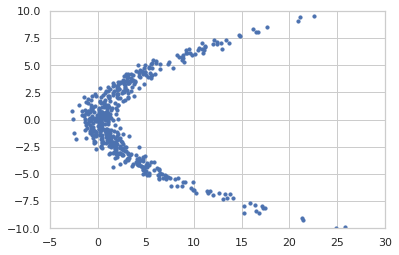

In [5]:
DATASET = 1
if DATASET == 0:
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
    dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=X.shape[0])
    dataset = dataset.prefetch(3 * batch_size)
    dataset = dataset.batch(batch_size)
    data_iterator = dataset.make_one_shot_iterator()
    X_train = data_iterator.get_next()
elif DATASET == 1:
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=DTYPE))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    X_train = sess.run(x_samples)
    plt.scatter(X_train[:, 0], X_train[:, 1], s=10)
    plt.xlim([-5, 30])
    plt.ylim([-10, 10])

In [6]:
n_dims = X_train.shape[1]

## Construct Flow

### Step 1. Define Invertible leaky rectified linear transformation

In [7]:
class PReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="p_relu"):
        super(PReLU, self).__init__(
            forward_min_event_ndims=0,
            validate_args=validate_args,
            name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        log_abs_det_J_inv = tf.log(tf.abs(J_inv))
        return log_abs_det_J_inv

### Step 2. Define MLP Normalizing Flow

In [8]:
# base distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))
d, r = 2, 2
bijectors = []

# create a fully connected network without non-linear activation function
for i in range(K):
    with tf.variable_scope('bijector_%d' % i):
        # define deterministic parameters
        V = tf.get_variable('V', [d, r], dtype=DTYPE)  # factor loading
        shift = tf.get_variable('shift', [d], dtype=DTYPE)  # affine shift
        L = tf.get_variable('L', [d*(d+1)/2], dtype=DTYPE)  # lower triangular
        alpha = tf.abs(tf.get_variable('alpha', [], dtype=DTYPE))+.01

        # Compute Y = g(X; shift, scale) = scale @ X + shift
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,
        ))
        bijectors.append(PReLU(alpha=alpha))

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

In [9]:
# Last layer is affine. Note that tfb.Chain takes a list of bijectors in the *reverse* order
# that they are applied.
mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])), name='2d_mlp_bijector')
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)
loss = -tf.reduce_mean(dist.log_prob(X_train))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


## Visualization (before training)

In [10]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [11]:
sess.run(tf.global_variables_initializer())

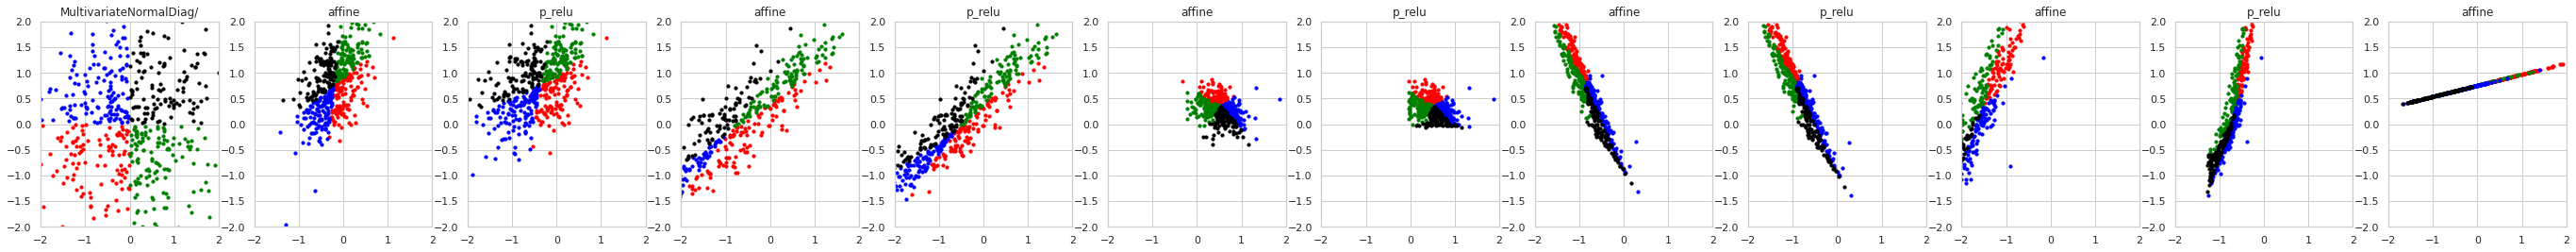

In [12]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

## Optimize Flow

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
NUM_STEPS = int(iterrations)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        print(i, np_loss)
        global_step.append(i)
    
    if i % 5000 == 0:
        np_losses.append(np_loss)

0 143034550000.0
1000 71235660.0
2000 23787576.0
3000 11124442.0
4000 6030018.0
5000 3579829.2
6000 2199441.5
7000 1363486.5
8000 844270.9
9000 521714.88
10000 318187.44
11000 192824.1
12000 115939.32
13000 68574.03
14000 40221.81
15000 23576.72
16000 13500.773
17000 7761.003
18000 4484.708
19000 2694.4053
20000 1641.7383
21000 967.4144
22000 544.56067
23000 311.51355
24000 187.67375
25000 111.48958
26000 66.50391
27000 38.309647
28000 21.430325
29000 12.431343
30000 9.172075
31000 8.285274
32000 7.9926853
33000 7.7498136
34000 7.4589057
35000 7.1995506
36000 6.982364
37000 6.841431
38000 6.686994
39000 6.446303
40000 6.1409097
41000 5.7503023
42000 5.309583
43000 4.9977956
44000 5.083582
45000 4.8111124
46000 4.708269
47000 4.720996
48000 4.75129
49000 4.7233453
50000 4.6893597
51000 4.6423254
52000 4.539794
53000 4.4778457
54000 4.4195037
55000 4.3847885
56000 4.366247
57000 4.3556023
58000 4.3536086
59000 4.350809
60000 4.358636
61000 4.349554
62000 4.3455067
63000 4.3451204
64000 4

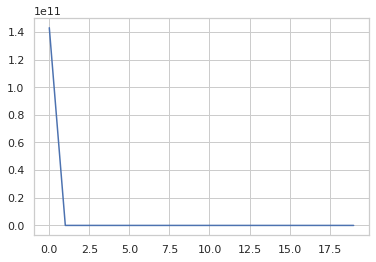

In [15]:
plt.plot(np_losses)

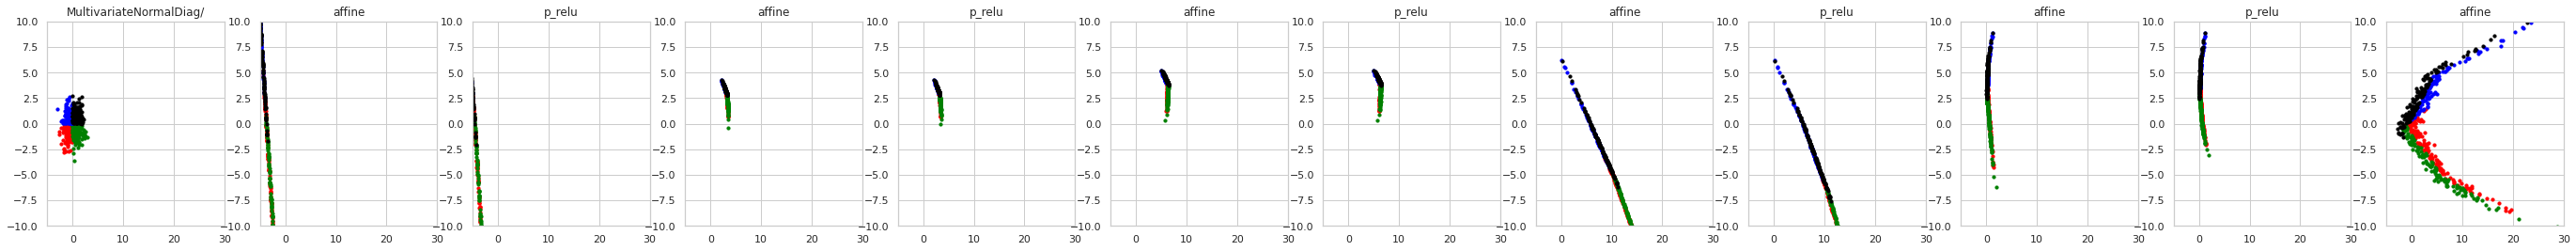

In [16]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')

    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')

    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')

    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    
    arr[i].set_xlim([-5, 30])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])
plt.show()

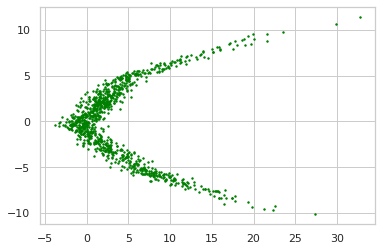

In [17]:
X1 = sess.run(dist.sample(1000))
plt.scatter(X1[:, 0], X1[:, 1], color='green', s=2)
arr[i].set_xlim([-5, 30])
arr[i].set_ylim([-10, 10])
plt.show()

Text(0, 0.5, 'Negative Log-Likelihood')

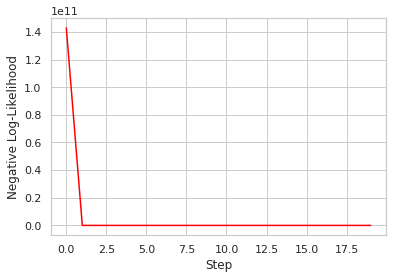

In [18]:
plt.plot(np_losses, c='red')
plt.xlabel('Step')
plt.ylabel('Negative Log-Likelihood')